In [1]:
import numpy as np
import pandas as pd
import os
import lightgbm as lgb
import xgboost as xgb
import time
from sklearn.kernel_ridge import KernelRidge
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from gplearn.genetic import SymbolicRegressor
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.svm import NuSVR, SVR
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import eli5

In [2]:
lgb_params = {'bagging_fraction': 0.8200000000000001,
 'boosting': 'goss',
 'feature_fraction': 0.6900000000000001,
 'lambda_l1': 2.767537387330119,
 'lambda_l2': 0.3565483800938233,
 'learning_rate': 0.1426787777244699,
 'max_bin': 164,
 'max_depth': 13,
 'metric': 'RMSE',
 'min_data_in_bin': 56,
 'min_data_in_leaf': 6,
 'min_gain_to_split': 3.42,
 'num_leaves': 1735,
 'objective': 'huber',
 'other_rate': 0.3000520182613355,
 'top_rate': 0.2514679376182475}


In [3]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

In [4]:
def createModel(X, y, X_test, cols, model = [], model_type = 'lgb', params = lgb_params, plot_feature_importance=True, ):       
    regrs = []
    oof_preds = np.zeros(len(X))
    feature_importance = pd.DataFrame()
    prediction = np.zeros(len(X_test))

    for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
        y = y.ravel()
        trn_x, trn_y = X[trn_], y[trn_]
        val_x, val_y = X[val_], y[val_]
        #scaler.fit(trn_x)
        #scaler.transform(trn_x)
        #scaler.transform(val_x)
        fold_importance = pd.DataFrame()
        
        if model_type == 'lgb':
            regr = lgb.LGBMRegressor(**params)
            regr.fit(
                trn_x, trn_y,
                eval_set=[(trn_x, trn_y), (val_x, val_y)],
                eval_metric='mae',
                verbose=False,
                early_stopping_rounds = 200
            )
            oof_preds[val_] = regr.predict(val_x)
            print('fold',fold_+1,mean_absolute_error(val_y, regr.predict(val_x)))
            y_pred = regr.predict(X_test, num_iteration=regr.best_iteration_)
        
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=trn_x, label=trn_y, feature_names = cols)
            valid_data = xgb.DMatrix(data=val_x, label=val_y, feature_names = cols)
            
            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            regr = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            oof_preds[val_] = regr.predict(xgb.DMatrix(val_x, feature_names = cols), ntree_limit=regr.best_ntree_limit)
            print('fold',fold_+1,mean_absolute_error(val_y, regr.predict(xgb.DMatrix(val_x, feature_names = cols), ntree_limit=regr.best_ntree_limit)))
            y_pred = regr.predict(xgb.DMatrix(X_test, feature_names = cols), ntree_limit=regr.best_ntree_limit)

        if model_type == 'sklearn':
            #regr = model
            
            etr = ExtraTreesRegressor(n_estimators=1000, max_depth=10)
            etr.fit(trn_x, trn_y)
            oof_preds[val_] = regr.predict(val_x).reshape(-1,)
            print('fold',fold_+1,mean_absolute_error(val_y, regr.predict(val_x).reshape(-1,)))
            y_pred = regr.predict(X_test).reshape(-1,)
            
            
        if model_type == 'cat':
            regr = CatBoostRegressor(  eval_metric='MAE', **params)
            regr.fit(trn_x, trn_y, eval_set=(val_x, val_y), cat_features=[], use_best_model=True, verbose=False)

            oof_preds[val_] = regr.predict(val_x)
            print('fold',fold_+1,mean_absolute_error(val_y, regr.predict(val_x)))
            y_pred = regr.predict(X_test)

        
        if model_type == 'lgb':        
            fold_importance["feature"] = cols
            fold_importance["importance"] = regr.feature_importances_
            fold_importance["fold"] = fold_ + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
        
        if model_type == "genetic":
            regr = SymbolicRegressor(population_size=10000,
                               tournament_size=50,
                               generations=100, #you can set a high number then use est_gp.set_params(generations= number<220) to stop evolution
                               stopping_criteria=0.0,
                               p_crossover=0.9, p_subtree_mutation=0.0001, p_hoist_mutation=0.0001, p_point_mutation=0.0001,
                               max_samples=1.0, verbose=1,
                               #function_set = ('add', 'sub', 'mul', 'div', gp_tanh, 'sqrt', 'log', 'abs', 'neg', 'inv','max', 'min', 'tan', 'cos', 'sin'),
                               function_set = ('tan', 'add', 'sub', 'mul', 'div','max', 'min'),
                               metric = 'mean absolute error', warm_start=True,
                               n_jobs = -1, parsimony_coefficient=0.00003, random_state=11)
            regr.fit(trn_x, trn_y)
            oof_preds[val_] = regr.predict(val_x).reshape(-1,)
            print('fold',fold_+1,mean_absolute_error(val_y, regr.predict(val_x)))
            y_pred = regr.predict(X_test)

        regrs.append(regr)
        prediction += y_pred
    loss = mean_absolute_error(y, oof_preds)
    if ((model_type == 'lgb') & (plot_feature_importance == True)):
        feature_importance["importance"] /= n_fold
        cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

        best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

        plt.figure(figsize=(16, 12));
        sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
        plt.title('LGB Features (avg over folds)');
        
        return loss, regrs, feature_importance, prediction
    prediction /= n_fold

    return loss, regrs, prediction

fold 1 2.1604101229545902
fold 2 1.9873293718354488
fold 3 2.155904982809222
fold 4 1.9745330586976948
fold 5 2.0720869673738913


/home/stamstath96/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:1857: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


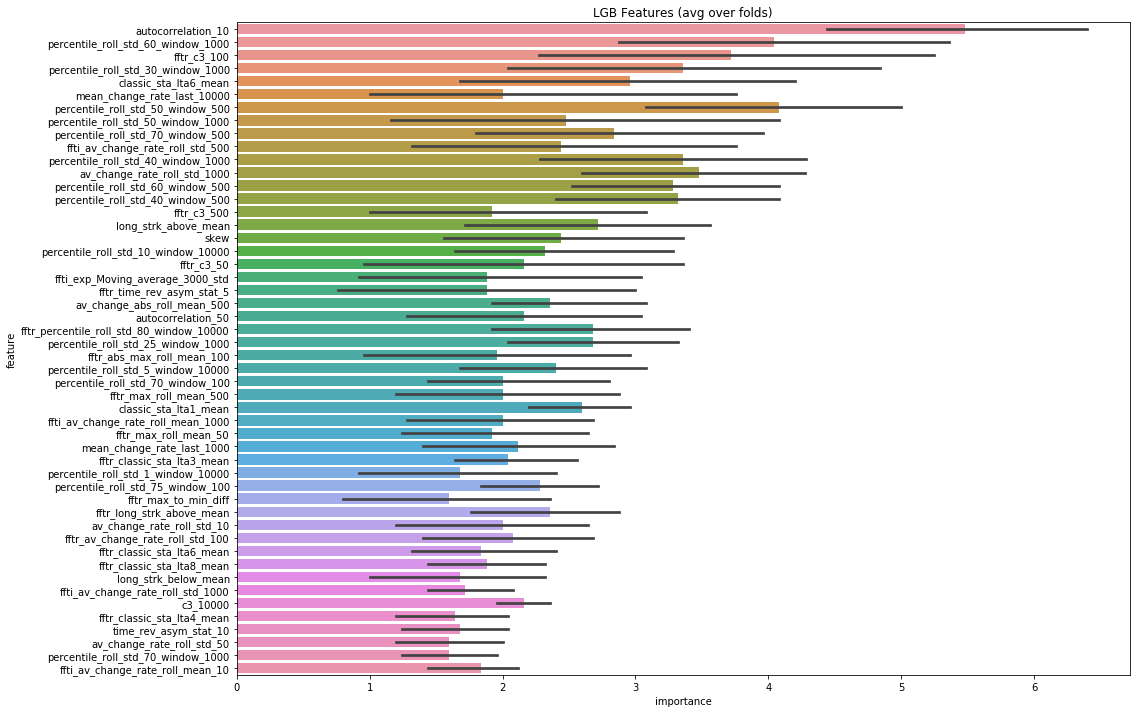

In [5]:
X_df = pd.read_csv('dataset/features_denoised.csv').drop(["Unnamed: 0", "seg_id", "target"], axis=1).replace([np.inf, -np.inf], np.nan)
y_df = pd.read_csv('dataset/features_denoised.csv').target
X_test_df = pd.read_csv("dataset/test_features_denoised.csv").drop(["Unnamed: 0", "seg_id", "target"], axis = 1).replace([np.inf, -np.inf], np.nan)
X = X_df.fillna(X_df.mean()).values
y = y_df.fillna(y_df.mean()).values
X_test = X_test_df.fillna(X_df.mean()).values

oof_lgb, regrs, feature_importance, prediction = createModel(X, y, X_test, X_df.columns)


In [7]:
from sklearn.neighbors import NearestNeighbors
# Generate nearest neighbor features
scaler = StandardScaler()
scaler.fit(X_df)
X_train_scaled = pd.DataFrame(scaler.transform(X_df), columns=X_df.columns).fillna(0)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_df), columns = X_test_df.columns).fillna(0)

n = 10
neigh = NearestNeighbors(n, n_jobs=-1)
neigh.fit(X_train_scaled)

dists, _ = neigh.kneighbors(X_train_scaled, n_neighbors=n)
mean_dist = dists.mean(axis=1)
max_dist = dists.max(axis=1)
min_dist = dists.min(axis=1)

X_train_scaled['mean_dist'] = mean_dist
X_train_scaled['max_dist'] = max_dist
X_train_scaled['min_dist'] = min_dist

test_dists, _ = neigh.kneighbors(X_test_scaled, n_neighbors=n)

test_mean_dist = test_dists.mean(axis=1)
test_max_dist = test_dists.max(axis=1)
test_min_dist = test_dists.min(axis=1)

X_test_scaled['mean_dist'] = test_mean_dist
X_test_scaled['max_dist'] = test_max_dist
X_test_scaled['min_dist'] = test_min_dist
top_cols = X_df.columns

/home/stamstath96/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/stamstath96/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  """
/home/stamstath96/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  


In [9]:
top_cols = list(feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index)
top_cols 

['min_roll_std_100',
 'min_roll_std_1000',
 'max_roll_mean_1000',
 'q05_roll_std_10',
 'skew',
 'min_roll_mean_1000',
 'q05_roll_std_100',
 'max_to_min',
 'mean_change_rate_first_10000',
 'q99_roll_mean_1000',
 'std_roll_mean_100',
 'av_change_abs_roll_mean_10',
 'min_roll_std_10',
 'q05_roll_std_1000',
 'q01_roll_mean_1000',
 'min_roll_mean_100',
 'q01_roll_std_10',
 'av_change_abs_roll_std_1000',
 'std_last_10000',
 'max_to_min_diff',
 'avg_first_10000',
 'q99_roll_std_1000',
 'mean_change_rate',
 'av_change_abs_roll_std_100',
 'q01_roll_std_1000',
 'av_change_abs_roll_std_10',
 'q95_roll_mean_100',
 'avg_first_50000',
 'abs_max',
 'av_change_abs_roll_mean_100',
 'classic_sta_lta1_mean',
 'q99_roll_mean_100',
 'abs_mean',
 'exp_Moving_average_30000_mean',
 'avg_last_50000',
 'mean_change_rate_first_50000',
 'max_roll_mean_100',
 'classic_sta_lta4_mean',
 'q95_roll_mean_1000',
 'mean_change_rate_last_10000',
 'abs_max_roll_mean_10',
 'max_roll_std_1000',
 'classic_sta_lta6_mean',
 'cl

In [8]:
X_df = pd.read_csv('dataset/features_denoised.csv').drop(["Unnamed: 0", "seg_id", "target"], axis=1).replace([np.inf, -np.inf], np.nan)
#X_df =  X_df[top_cols]
y_df = pd.read_csv('dataset/features_denoised.csv').target
X_test_df = pd.read_csv("dataset/test_features_denoised.csv").drop(["Unnamed: 0", "seg_id", "target"], axis = 1).replace([np.inf, -np.inf], np.nan)
X = X_df.fillna(X_df.mean()).values
y = y_df.fillna(y_df.mean()).values
X_test = X_test_df.fillna(X_df.mean()).values


oof_lgb, lgb_regrs, lgb_predictions = createModel(X, y, X_test, X_df.columns, plot_feature_importance=False)


fold 1 2.1604101229545902
fold 2 1.9873293718354488
fold 3 2.155904982809222
fold 4 1.9745330586976948
fold 5 2.0720869673738913


In [9]:
lgb_predictions

array([3.43834903, 5.64499759, 5.61507653, ..., 3.90001057, 1.60497266,
       9.06155543])

In [10]:
xgb_params = {'boosting': 'gblinear',
 'colsample_bylevel': 0.46,
 'colsample_bynode': 0.6900000000000001,
 'colsample_bytree': 0.14,
 'eval_metric': 'mae',
 'gamma': 3.547472486318506,
 'learning_rate': 0.19975149847373147,
 'max_depth': 4,
 'min_child_weight': 3.7076616207738655,
 'objective': 'reg:linear',
 'reg_alpha': 0.3700067743324519,
 'reg_lambda': 0.3915612258266841,
 'subsample': 0.8500000000000001,
 'tree_method': 'approx'}


import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

top_cols = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in top_cols]
oof_xgb, xgb_regrs, xgb_predictions = createModel(X, y, X_test, top_cols, params=xgb_params,  model_type='xgb')

[0]	train-mae:4.25226	valid_data-mae:4.39064
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[13]	train-mae:1.8608	valid_data-mae:2.15621

fold 1 2.156212083631076
[0]	train-mae:4.30568	valid_data-mae:4.14826
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[10]	train-mae:1.92861	valid_data-mae:2.03221

fold 2 2.0322110488762033
[0]	train-mae:4.26563	valid_data-mae:4.32802
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[13]	train-mae:1.85609	valid_data-mae:2.17881

fold 3 2.178805800109109
[0]	train-mae:4.28097	valid_data-mae:4.23508
Multiple eval metrics have been passed: 'valid_data-mae' will be

In [20]:
oof_gen, gen_regrs, gen_predictions = createModel(X, y, X_test, top_cols, params=xgb_params,  model_type='genetic')

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    19.48      8.01509e+37        7          2.59171              N/A      8.25m
   1     4.13       7.7378e+13        6          2.57891              N/A     37.54m
   2     4.11      3.23737e+08        8          2.39565              N/A     47.26m
   3     5.89      1.93476e+13       11          2.33592              N/A     70.11m
   4     7.38      1.93444e+13       14          2.30665              N/A     54.84m
   5     9.74      1.93444e+13       17          2.30601              N/A     52.70m


/home/stamstath96/anaconda3/lib/python3.5/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


   6    13.61          10.3784       18          2.29004              N/A     63.91m
   7    15.62          4.96291       18          2.29004              N/A     67.38m
   8    17.87          7.47068       28          2.26093              N/A     68.54m
   9    18.67          10.2951       28          2.22002              N/A     70.46m
  10    24.74          13.0529       30          2.20976              N/A     69.04m
  11    30.37          14.3763       32          2.20386              N/A     78.05m
  12    31.31          14.4839       37           2.1992              N/A     82.95m
  13    32.48          10.8622       38          2.19518              N/A     87.98m
  14    35.06           20.969       44          2.19301              N/A     86.34m
  15    38.11          16.9052       45          2.18937              N/A     95.06m
  16    40.56          13.7455       45          2.18937              N/A     96.91m
  17    42.17           14.934       38          2.18611         

/home/stamstath96/anaconda3/lib/python3.5/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


  21    41.42          19.4775       47          2.18559              N/A     90.29m
  22    46.23          4.61758       45          2.18559              N/A    108.03m
  23    45.05          4.00326       45          2.18559              N/A    100.87m
  24    44.84          3.91381       45          2.18559              N/A    110.69m
  25    44.98           11.147       45          2.18559              N/A    153.71m
  26    45.02          3.84967       45          2.18559              N/A    167.92m
  27    45.09          3.87508       45          2.18559              N/A    166.00m
  28    44.65          3.90733       45          2.18559              N/A    159.15m
  29    44.84          3.88005       45          2.18559              N/A    164.39m
  30    45.02          3.87378       45          2.18559              N/A    156.72m
  31    45.19          3.92613       45          2.18559              N/A    154.43m
  32    45.08            41602       45          2.18559         

  15    70.95          2.84429      121          2.28219              N/A    122.08m
  16    75.42          23.9612      121          2.28219              N/A    121.39m
  17    91.41          2.88693      105          2.24328              N/A    141.05m
  18   122.31          3.02514      120          2.22904              N/A    133.60m
  19   126.18          3.03661      110          2.21549              N/A    141.03m
  20   122.16          2.97529      192          2.19649              N/A    168.52m
  21   131.62          2.94417      165          2.19473              N/A    151.26m
  22   145.16           2.8992      193          2.19018              N/A    170.47m
  23   190.27          2.96286      195          2.18693              N/A    179.86m
  24   173.37          2.94847      225          2.18368              N/A    187.90m
  25   188.85          2.83149      195          2.18158              N/A    193.14m
  26   203.47          2.86025      317          2.17693         

/home/stamstath96/anaconda3/lib/python3.5/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


  64   425.20          2.81746      460          2.08828              N/A    208.96m


/home/stamstath96/anaconda3/lib/python3.5/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


  65   447.31          2.81594      507          2.08338              N/A    197.35m


/home/stamstath96/anaconda3/lib/python3.5/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


  66   466.66          2.78337      684          2.07979              N/A    197.90m
  67   454.33          3.42351      684          2.07979              N/A    208.26m
  68   439.50          3.07449      490          2.07924              N/A    214.26m
  69   440.65          2.80115      436          2.07709              N/A    196.41m


/home/stamstath96/anaconda3/lib/python3.5/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


  70   440.92          2.70115      828          2.07561              N/A    197.70m


/home/stamstath96/anaconda3/lib/python3.5/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


  71   438.99          2.81769      825          2.07396              N/A    185.56m


/home/stamstath96/anaconda3/lib/python3.5/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


  72   441.28          5.98883      549          2.07016              N/A    166.56m


/home/stamstath96/anaconda3/lib/python3.5/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


  73   436.45          2.79086      547          2.06563              N/A    168.46m
  74   450.87          3.87026      680          2.06404              N/A    158.38m
  75   511.41          29.5785      689           2.0617              N/A    164.77m
  76   533.79          9.95189      895          2.05887              N/A    156.86m
  77   538.92          2.74331      528           2.0568              N/A    162.09m
  78   537.65          2.58731      656          2.05488              N/A    164.40m


/home/stamstath96/anaconda3/lib/python3.5/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


  79   538.41          2.59302      644          2.05196              N/A    154.50m


/home/stamstath96/anaconda3/lib/python3.5/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


  80   533.25          4.17404      627          2.04961              N/A    152.90m


/home/stamstath96/anaconda3/lib/python3.5/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


  81   509.20          11.4281      845          2.04744              N/A    129.62m


/home/stamstath96/anaconda3/lib/python3.5/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


  82   499.10          2.70777      584          2.04564              N/A    125.51m
  83   547.36          2.59708      756          2.04451              N/A    110.94m
  84   512.45          3.75781      530          2.04329              N/A    108.66m
  85   540.23           2.6126      559          2.04205              N/A    106.63m
  86   536.57          1273.15      525          2.04032              N/A    101.03m
  87   529.36          37.1111      526          2.03951              N/A     98.60m
  88   524.56          2.61949      501          2.03922              N/A     87.53m
  89   520.17          2.62513      505          2.03838              N/A     81.24m
  90   509.14          5203.61      489          2.03762              N/A     71.98m
  91   503.34           2.6531      489          2.03762              N/A     55.42m
  92   499.68           2.6561      527          2.03652              N/A     53.46m
  93   492.71          2.63921      527          2.03652         

/home/stamstath96/anaconda3/lib/python3.5/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


  97   490.72          2.66342      538          2.03485              N/A     15.08m
  98   488.31          2.63925      538          2.03485              N/A      7.66m
  99   492.39          2.61047      612          2.03471              N/A      0.00s
fold 2 1.9794976391759693
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    19.48      8.69872e+37        7          2.58856              N/A      9.59m
   1     4.15      8.39078e+13        6          2.58665              N/A     36.76m
   2     4.11      3.69054e+08        8          2.40172              N/A     46.41m
   3     5.88      2.09809e+13       11          2.34563              N/A     46.36m
   4     7.37      2.09768e+13       14          2.31434              N/A     47.62m
   5     9.22          18.8399       14          

  91    19.09          34.6325       21          2.30464              N/A      7.72m
  92    19.09          40.0336       21          2.30464              N/A      8.51m
  93    19.01          31.7417       21          2.30464              N/A      7.15m
  94    18.98          34.4391       21          2.30464              N/A      6.00m
  95    19.05          46.4672       21          2.30464              N/A      3.76m
  96    18.90          27.2619       21          2.30464              N/A      3.73m
  97    19.14          22.0244       21          2.30464              N/A      2.42m
  98    18.88          24.4002       21          2.30464              N/A     57.04s
  99    18.96           29.307       21          2.30464              N/A      0.00s
fold 3 2.396270871717633
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          F

  85   156.91          2.73913      169          2.08252              N/A     82.25m
  86   156.23          2.71842      159          2.08254              N/A     73.76m
  87   156.76            2.742      169          2.08252              N/A     67.47m
  88   156.84          2.74742      162          2.08253              N/A     65.91m
  89   156.37          2.75228      162          2.08253              N/A     56.24m
  90   156.82          2.75607      169          2.08252              N/A     51.21m
  91   157.42           2.7266      169          2.08252              N/A     45.97m
  92   156.92          2.73538      159          2.08254              N/A     40.48m
  93   157.15          2.73527      162          2.08253              N/A     36.13m
  94   156.81          2.74885      169          2.08252              N/A     28.71m
  95   157.37          2.72367      169          2.08252              N/A     23.17m
  96   156.93          2.75176      162          2.08253         

/home/stamstath96/anaconda3/lib/python3.5/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


  78   218.26          2.80616      176          2.07983              N/A     62.28m
  79   209.14          2.85388      161          2.07684              N/A     62.65m
  80   196.03          2.88693      155          2.07525              N/A     63.28m
  81   170.89           160741      195          2.07335              N/A     59.56m
  82   169.34          2.91236      211          2.07073              N/A     51.41m
  83   165.73          2.89381      191           2.0706              N/A     40.47m
  84   179.20          3.05593      253          2.06957              N/A     41.47m
  85   181.92          2.82904      195          2.06907              N/A     41.32m
  86   176.55          2.86635      197          2.06901              N/A     37.74m
  87   165.42           3.0242      163          2.06862              N/A     35.37m
  88   155.98          3.13075      161          2.06857              N/A     30.90m
  89   147.19           3.0871      139          2.06816         

In [22]:
pd.DataFrame(gen_predictions).to_csv("gen_preds.csv")

In [13]:
gen_predictions = np.array(pd.read_csv("gpsubmission.csv").time_to_failure)
gen_predictions

array([3.1634503 , 5.12290349, 4.87831656, ..., 4.6917265 , 1.84833649,
       9.06817592])

In [15]:
#oof_sk, sk_regrs, sk_predictions = createModel(X, y, X_test, top_cols, params=xgb_params,  model_type='sklearn')

In [ ]:
params = {'depth':12,
          'iterations':50000,
          'learning_rate':0.19975149847373147 ,
          'l2_leaf_reg':3,
          'border_count':12,
          'verbose':True,
          'thread_count':4}


oof_cat, cat_regs, cat_predictions = createModel(X, y, X_test, top_cols, params = params,  model_type='cat')

In [14]:
train_stack = np.vstack([oof_lgb, oof_xgb, oof_gen]).transpose()
train_stack = pd.DataFrame(train_stack, columns = ['lgb', 'xgb', 'gen'])
test_stack = np.vstack([lgb_predictions, xgb_predictions, gen_predictions]).transpose()
test_stack = pd.DataFrame(test_stack)

NameError: name 'oof_gen' is not defined

In [12]:
# Load submission file
submission = pd.read_csv('dataset/sample_submission.csv', index_col='seg_id', dtype={"time_to_failure": np.float32})
submission['time_to_failure'] = (lgb_predictions + xgb_predictions + gen_predictions) / 3
# submission['time_to_failure'] = prediction_lgb_stack
submission.to_csv('submission.csv')

submission.head()

,time_to_failure
seg_id,
seg_00030f,3.483340
seg_0012b5,5.667366
seg_00184e,5.668453
seg_003339,8.535632
seg_0042cc,6.677124
